In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import io 
sys.path.append("../scripts")
sys.path.append("../")
from data_cleaner import DataCleaner
from util import Util
from plotter import Plotter

In [2]:
util = Util()
cleaner=DataCleaner()
plotter = Plotter()
cwd = os.getcwd()


### read  our data 
We have:<br>
store.csv with tag (store-v0) <br>
test.csv with tag (test-v0) <br>
train.csv with tag (train-v0)

In [3]:
repo="../"

store=util.read_from_dvc("data/store.csv",repo,"store-v0",low_memory=False)
test=util.read_from_dvc("data/test.csv",repo,"test-v0",low_memory=False)
train=util.read_from_dvc("data/train.csv",repo,"train-v0",low_memory=False)

### Store df consists of detailed information about each store

In [4]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### test data consists sales information on a daily basis (just without sales amount, that's what we need to predict)

In [5]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


Stores with NaN values of 'Open' on a specific date

In [7]:
test[test.isnull()["Open"]][["Store","Date","Open"]]

,Store,Date,Open
479,622,2015-09-17,NaN
1335,622,2015-09-16,NaN
2191,622,2015-09-15,NaN
3047,622,2015-09-14,NaN
4759,622,2015-09-12,NaN
5615,622,2015-09-11,NaN
6471,622,2015-09-10,NaN
7327,622,2015-09-09,NaN
8183,622,2015-09-08,NaN
9039,622,2015-09-07,NaN


### train data consists sales information and sales amount on a daily basis

In [8]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


fill missing data in store df

In [10]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
# view promo2sinceX values for rows that have promo2=0 (for stores not participating in consecutive promotions)
store[store["Promo2"]==0][["Promo2","Promo2SinceWeek","Promo2SinceYear","PromoInterval"]]



,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
5,0,NaN,NaN,NaN
6,0,NaN,NaN,NaN
...,...,...,...,...
1107,0,NaN,NaN,NaN
1109,0,NaN,NaN,NaN
1111,0,NaN,NaN,NaN
1112,0,NaN,NaN,NaN


we can see whenever promo2==0 we have missing values for PromoSinceX and PromoInterval (which actually makes sense because they are not participating in any consecutive promotion) <br>
so we can fill them with 0 (for float dtypes) and null (for object dtypes)

In [12]:
store["Promo2SinceWeek"].fillna(0,inplace=True)
store["Promo2SinceYear"].fillna(0,inplace=True)
store["PromoInterval"].fillna('null',inplace=True)

In [13]:
store[store["Promo2"]==0][["Promo2SinceWeek","Promo2SinceYear","PromoInterval"]]

,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0.0,0.0,null
3,0.0,0.0,null
4,0.0,0.0,null
5,0.0,0.0,null
6,0.0,0.0,null
...,...,...,...
1107,0.0,0.0,null
1109,0.0,0.0,null
1111,0.0,0.0,null
1112,0.0,0.0,null


In [14]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

From the above data we can see that even though there are stores where there is a competiting store nearby, there are about 351 stores where we don't know when the competing store was opened. Possible interpretation of this would be the competing stores may have existed before the store in reference was opened. In that case it would not make sense to replace(fill) these columns with either mean or median. Filling with zero makes better sense.

In [15]:
store['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
store['CompetitionOpenSinceYear'].fillna(0,inplace=True)

In [16]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          3
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

now we only have 3 rows missing in competitionDistance, let's look at them


In [17]:
store[store["CompetitionDistance"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,0.0,0.0,0,0.0,0.0,null
621,622,a,c,NaN,0.0,0.0,0,0.0,0.0,null
878,879,d,a,NaN,0.0,0.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


before handling missing values of Competition Distance, we have to check for skewness of the data

In [18]:
skew_data_store=pd.DataFrame(data=["CompetitionDistance"],columns=["Features"])

skew_data_store["Skew"]=store["CompetitionDistance"].skew()

skew_data_store["Absolute Skew"] = skew_data_store["Skew"].abs()

skew_data_store["Skewed"] = skew_data_store["Absolute Skew"].apply(lambda x : True if x else False)

skew_data_store


,Features,Skew,Absolute Skew,Skewed
0,CompetitionDistance,2.929286,2.929286,True


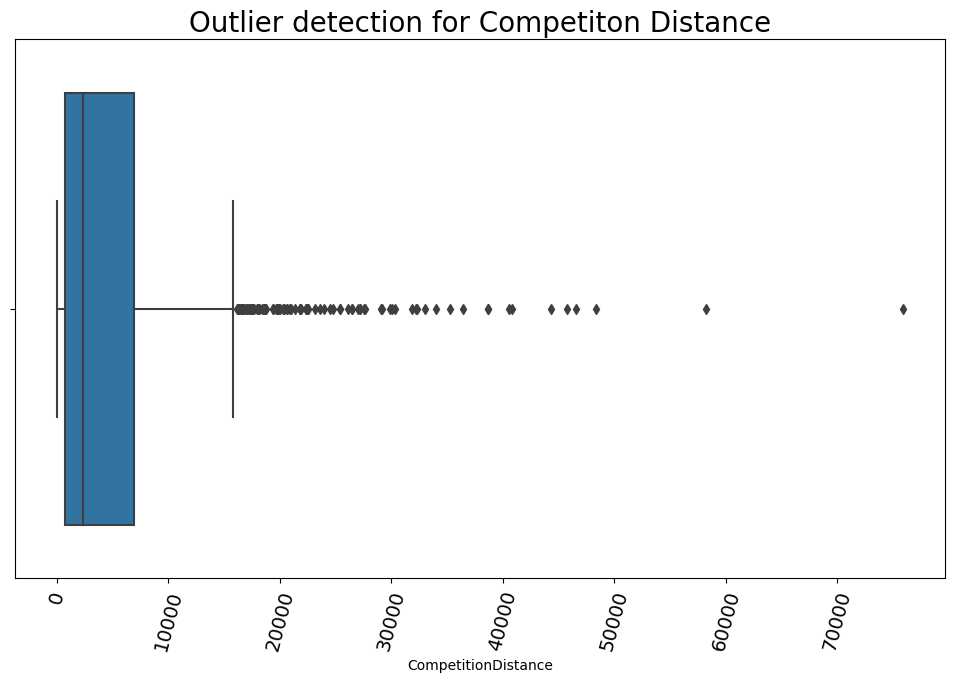

In [19]:
plotter.plot_box(store,"CompetitionDistance","Outlier detection for Competiton Distance")

#### Fill missing data
- Categorical columns will be filled using mode() / frequent values
- numerical columns can be filled with either median or mean
 - for numerical columns the decision to use which method will be determined by observing the skewness of the data
 - When the data is skewed, it is good to consider using the median value for replacing the missing values. Note that imputing missing data with median value can only be done with numerical data.
#### checking for skew
- 0 means No skew
- +ve value means right skew
- -ve value means left skew
- should also be handled with outlier handler

In [20]:
# CompetitionDistance is a right skewed data 
# it is recomended to use median method for skewed_features

store=cleaner.fill_missing_values_numeric(store,"median",["CompetitionDistance"])


In [21]:
# we have now completed filling missing values
store.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [22]:
# uncomment this for the first run only
# store.to_csv('../data/store.csv',index=False)

### merge our train and test data with the store data in order to get a good grasp of stores' info in each set

In [23]:
complete_train=store.merge(train,on="Store")
complete_train.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,1,2015-07-27,6102,612,1,1,0,1


In [24]:
complete_test=store.merge(test,on="Store")
complete_test.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Id,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,1,4,2015-09-17,1.0,1,0,0
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,857,3,2015-09-16,1.0,1,0,0
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,1713,2,2015-09-15,1.0,1,0,0
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,2569,1,2015-09-14,1.0,1,0,0
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null,3425,7,2015-09-13,0.0,0,0,0


In [25]:
complete_test=cleaner.convert_to_datetime(complete_test,["Date"])
complete_train=cleaner.convert_to_datetime(complete_train,["Date"])

In [26]:
cleaner.percent_missing_column(complete_test,complete_test.columns)

,Col Name,Total,Missing,%,Data Type
13,Open,41088,11,0.03,float64
0,Store,41088,0,0.00,int64
9,PromoInterval,41088,0,0.00,object
15,StateHoliday,41088,0,0.00,object
14,Promo,41088,0,0.00,int64
12,Date,41088,0,0.00,datetime64[ns]
11,DayOfWeek,41088,0,0.00,int64
10,Id,41088,0,0.00,int64
8,Promo2SinceYear,41088,0,0.00,float64
1,StoreType,41088,0,0.00,object


In [27]:
cleaner.percent_missing_column(complete_train,complete_train.columns)


,Col Name,Total,Missing,%,Data Type
0,Store,1017209,0,0.0,int64
1,StoreType,1017209,0,0.0,object
16,StateHoliday,1017209,0,0.0,object
15,Promo,1017209,0,0.0,int64
14,Open,1017209,0,0.0,int64
13,Customers,1017209,0,0.0,int64
12,Sales,1017209,0,0.0,int64
11,Date,1017209,0,0.0,datetime64[ns]
10,DayOfWeek,1017209,0,0.0,int64
9,PromoInterval,1017209,0,0.0,object


see if we have sound values in each columns (according to the dataset fields description)

In [28]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [29]:

print(store['CompetitionOpenSinceMonth'].unique())
print(store['StoreType'].unique())
print(store['Promo2'].unique())
print(store['Assortment'].unique())

[ 9. 11. 12.  4. 10.  8.  0.  3.  6.  5.  1.  2.  7.]
['c' 'a' 'd' 'b']
[0 1]
['a' 'c' 'b']


In [30]:
complete_train.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [31]:
print(complete_train['PromoInterval'].unique())
print(complete_train['DayOfWeek'].unique())
print(complete_train['Open'].unique())
print(complete_train['Promo'].unique())
print(complete_train['StateHoliday'].unique())
print(complete_train['SchoolHoliday'].unique())

['null' 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
[5 4 3 2 1 7 6]
[1 0]
[1 0]
['0' 'a' 'b' 'c']
[1 0]


In [32]:
print(complete_test['PromoInterval'].unique())
print(complete_test['DayOfWeek'].unique())
print(complete_test['Open'].unique())
print(complete_test['Promo'].unique())
print(complete_test['StateHoliday'].unique())
print(complete_test['SchoolHoliday'].unique())

['null' 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
[4 3 2 1 7 6 5]
[ 1.  0. nan]
[1 0]
['0' 'a']
[0 1]


### we have to handle those missing values

since we are dealing with time series data here, it is acceptable to use 
- ffill,
- bfill,
- interpolation


In [33]:
# as seen from the above tables, Promo2SinceYear, Promo2SinceWeek, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, and Open are float data types
# we don't want to treat them as a number when filling missing values
# we shold convert them to str, fill missing data, and convert back to numbers

# target_cols=['Promo2SinceYear','Promo2SinceWeek','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Open']

# complete_test=cleaner.convert_to_string(complete_test,target_cols)
# complete_train=cleaner.convert_to_string(complete_train,target_cols)


In [34]:
# get all numerical columns and name them features
skew_data_test=pd.DataFrame(data=cleaner.get_numerical_columns(complete_test),columns=["Features"])
skew_data_train=pd.DataFrame(data=cleaner.get_numerical_columns(complete_train),columns=["Features"])

# get skew value for each column
skew_data_test["Skew"]=list(complete_test[cleaner.get_numerical_columns(complete_test)].skew())
skew_data_train["Skew"]=list(complete_train[cleaner.get_numerical_columns(complete_train)].skew())

# we don't care the direction of the skew (can be left skewed or right skewed) we only want its magnitude thus we take the absolute value of the skew
skew_data_test["Absolute Skew"] = skew_data_test["Skew"].abs()
skew_data_train["Absolute Skew"] = skew_data_train["Skew"].abs()
# we say a data is skewed if its absolute value is greater than .5
skew_data_test["Skewed"] = skew_data_test["Absolute Skew"].apply(lambda x : True if x>=0.5 else False) 
skew_data_train["Skewed"] = skew_data_train["Absolute Skew"].apply(lambda x : True if x>=0.5 else False) 


In [35]:
skew_data_test

,Features,Skew,Absolute Skew,Skewed
0,Store,0.010899,0.010899,False
1,CompetitionDistance,3.422234,3.422234,True
2,CompetitionOpenSinceMonth,0.339072,0.339072,False
3,CompetitionOpenSinceYear,-0.536991,0.536991,True
4,Promo2,-0.326715,0.326715,False
5,Promo2SinceWeek,0.687181,0.687181,True
6,Promo2SinceYear,-0.326710,0.326710,False
7,Id,0.000000,0.000000,False
8,DayOfWeek,0.028468,0.028468,False
9,Open,-2.008802,2.008802,True


from the above table we can clearly see that competition distance is skewed,  we cannot take others as skewed because only competition distance is truly numeric

In [36]:
skew_data_train

,Features,Skew,Absolute Skew,Skewed
0,Store,-0.000955,0.000955,False
1,CompetitionDistance,2.933465,2.933465,True
2,CompetitionOpenSinceMonth,0.189174,0.189174,False
3,CompetitionOpenSinceYear,-0.782138,0.782138,True
4,Promo2,-0.002255,0.002255,False
5,Promo2SinceWeek,1.003390,1.003390,True
6,Promo2SinceYear,-0.002251,0.002251,False
7,DayOfWeek,0.001593,0.001593,False
8,Sales,0.641460,0.641460,True
9,Customers,1.598650,1.598650,True


from the above table we can clearly see that competition distance is skewed,  we cannot take others as skewed because only competition,sales, and customers col are truly numeric

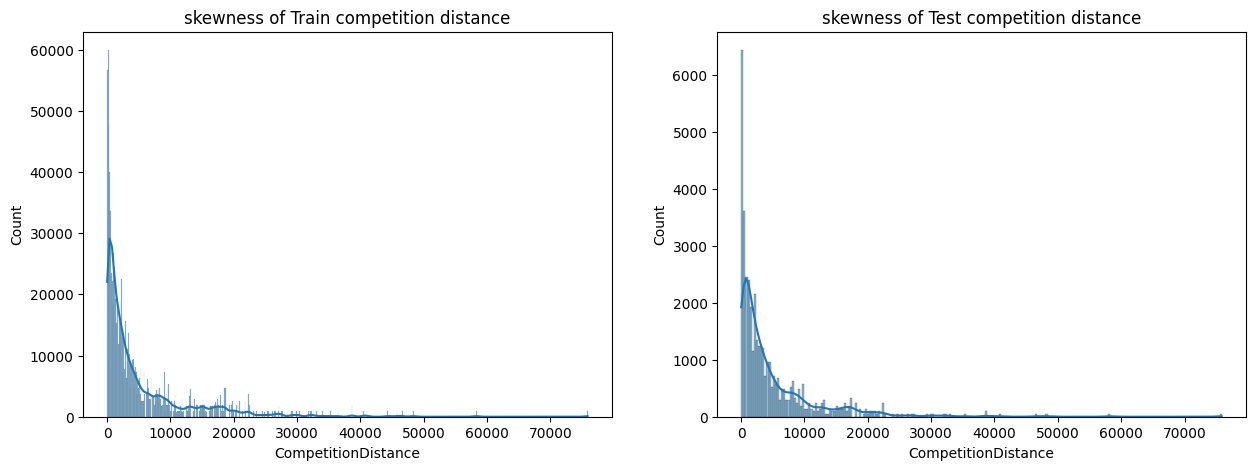

In [37]:
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1,title="skewness of Train competition distance")
sns.histplot(complete_train["CompetitionDistance"],kde=True)

plt.subplot(1,2,2,title="skewness of Test competition distance")
sns.histplot(complete_test["CompetitionDistance"],kde=True)

plt.show()

In [38]:
# get skewed column names 
# skewed_features= skew_data_test.query("Skewed")
# skewed_features = list(skewed_features["Features"])

# it is recomended to use median method for skewed_features
# complete_test=cleaner.fill_missing_values_numeric(complete_test,"median",["CompetitionDistance"])
# complete_train=cleaner.fill_missing_values_numeric(complete_train,"median",["CompetitionDistance"])

# complete_test=cleaner.fill_missing_values_categorical(complete_test,"mode",columns=["CompetitionOpenSinceMonth","CompetitionOpenSinceYear","Promo2SinceWeek","Promo2SinceYear","PromoInterval"])
# complete_train=cleaner.fill_missing_values_categorical(complete_train,"mode",columns=["CompetitionOpenSinceMonth","CompetitionOpenSinceYear","Promo2SinceWeek","Promo2SinceYear","PromoInterval"])


In [39]:
# version our data as v1
# uncomment these lines for the first run only
# complete_train.to_csv('../data/train.csv', index=False)
# complete_test.to_csv('../data/test.csv', index=False)

In [40]:
# from the aboce table we can clearly see that competition distance is skewed,  we cannot take others as skewed because only competition distance is truly numeric
skewed_cols_test=["CompetitionDistance"]

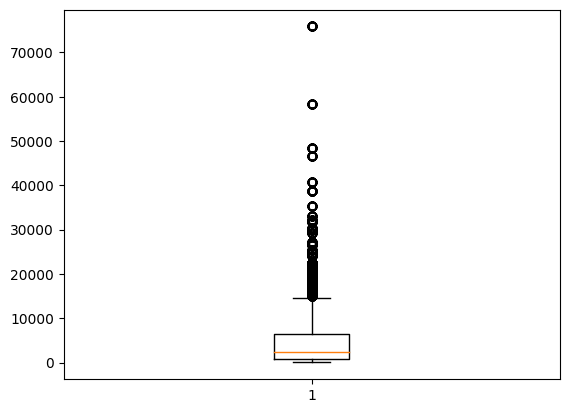

In [41]:

plt.boxplot(complete_test[skewed_cols_test])
plt.show()

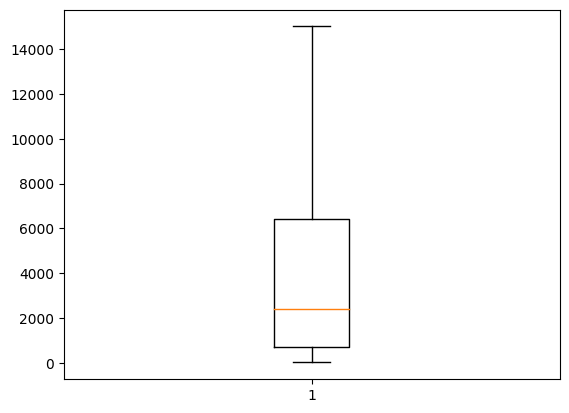

In [42]:
complete_test=cleaner.handle_outliers(complete_test,"CompetitionDistance")
plt.boxplot(complete_test[skewed_cols_test])
plt.show()

In [43]:
complete_train.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [44]:
skewed_cols_train=["CompetitionDistance","Customers","Sales"]

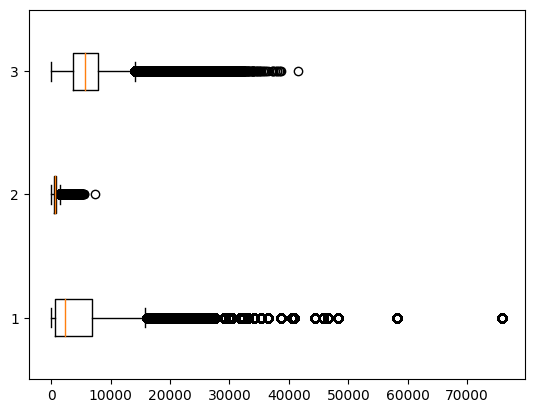

In [45]:
plt.boxplot(complete_train[skewed_cols_train],vert=False)
plt.show()

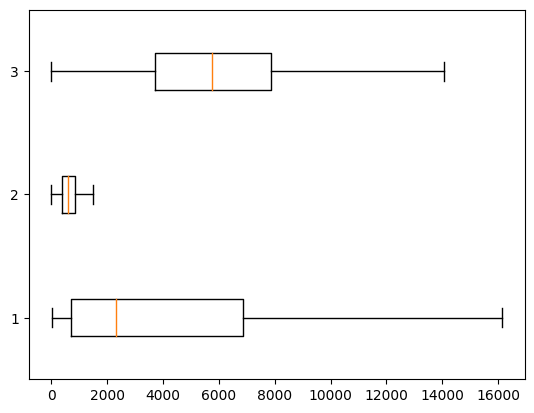

In [46]:
for col in skewed_cols_train:
    complete_train=cleaner.handle_outliers(complete_train,col)

plt.boxplot(complete_train[skewed_cols_train],vert=False)
plt.show()